In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.dates as mdates



## Data Handling

In [186]:
# Import csv file from data folder
data = pd.read_csv('../Data/Price.csv')

# Explore data
print("Columns of dataset:", data.columns)
print("Price Areas: ", data['PriceArea'].unique())

# Filter all rows that do not equal DE for the column Country
data = data[data['PriceArea'] == 'DK2'].reset_index(drop=True) # adjust for DK2, not DE here!
data = data.drop(columns=['PriceDKK', 'PriceArea'])
data = data.rename(columns={'HourDK': 'Date', 'PriceEUR': 'Price', 'HourUTC': 'Hour'})
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')  # Convert to standard format
data['Hour'] = pd.to_timedelta(data['Hour']) + pd.Timedelta(hours=1) # Shift to UTC+1
data['Hour'] = data['Hour'].apply(lambda x: x - pd.Timedelta(days=1) if x >= pd.Timedelta(days=1) else x) # Handles the 24:00:00 case
data['Datetime'] = pd.to_datetime(data['Date']) + data['Hour']
data['Hour'] = data['Hour'].apply(lambda x: str(x).split(' ')[-1])
data['Hour'] = (pd.to_datetime(data['Hour'], format='%H:%M:%S')).dt.time
data.head(25)

Columns of dataset: Index(['HourUTC', 'HourDK', 'PriceArea', 'PriceDKK', 'PriceEUR'], dtype='object')
Price Areas:  ['DE' 'SE3' 'DK2' 'DK1' 'NO2' 'SE4' 'SYSTEM']


,Hour,Date,Price,Datetime
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00


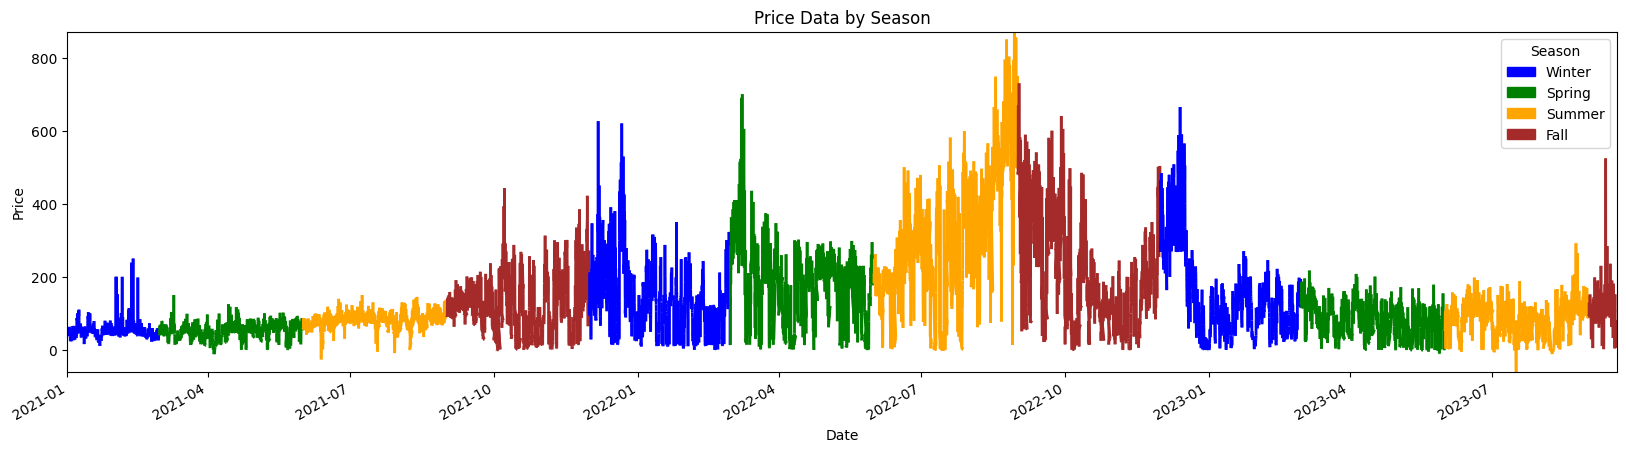

In [187]:
# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a season column
data['Season'] = data['Datetime'].apply(get_season)

# Map seasons to colors
season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}
data['Color'] = data['Season'].map(season_colors)

# Prepare data for LineCollection
dates = data['Datetime'].values
prices = data['Price'].values
points = np.array([mdates.date2num(dates), prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = data['Color'].values[:-1]  # Create color array for segments

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=2)

# Plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.add_collection(lc)
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min(), prices.max())
ax.set_title('Price Data by Season')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Format x-axis with proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
ax.legend(handles=legend_handles, title='Season')
plt.show()

# Drop auxiliary columns
data = data.drop(columns=['Season', 'Color'])

Sacko Implementation (adjusted):

Total number of elements in the dataframe for region 'DK2': 23783
Number of elements in each category (equal-sized bins):
Category
Category 1    5946
Category 2    5946
Category 3    5945
Category 4    5946
Name: count, dtype: int64


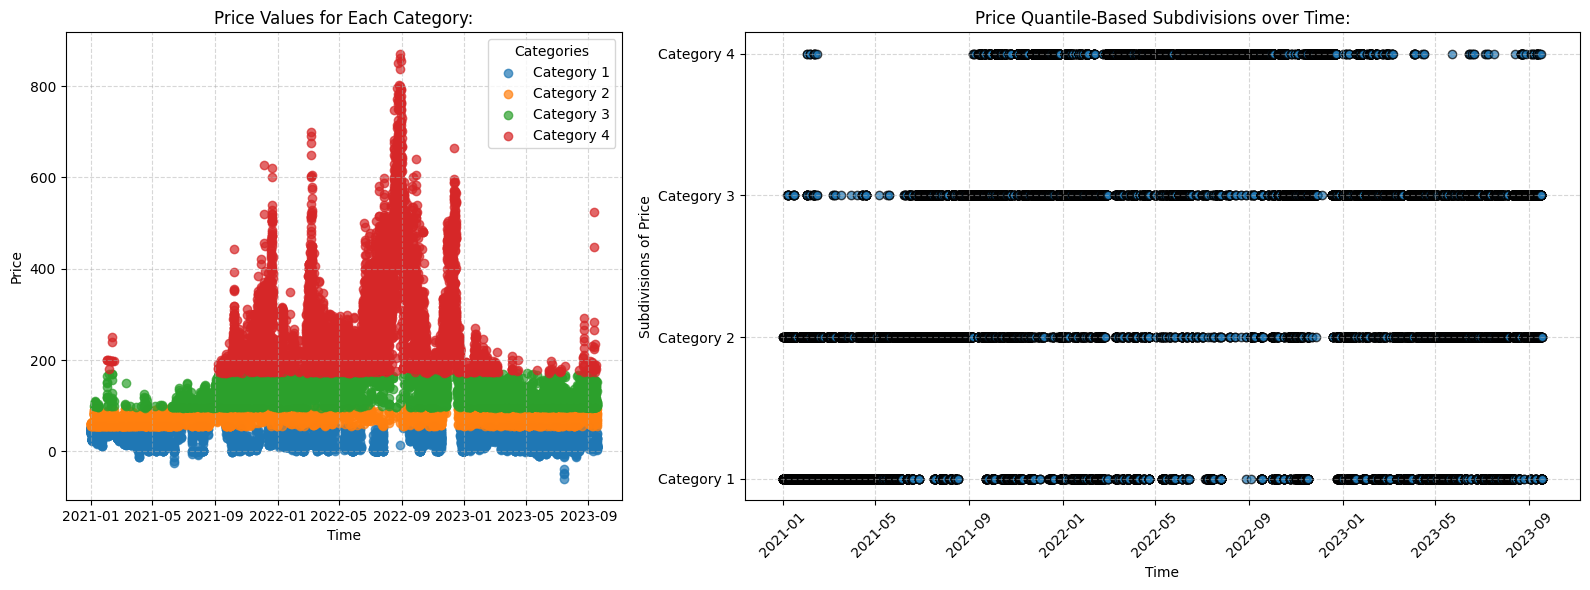

In [188]:
def plot_qcut(df, column, subdivisions, time_column):
    """
    Create a subplot with the quantile-based subdivisions scatter plot on the right and 
    line plots of the prices for each category on the left.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the data.
        region (str): The region to filter the data by.
        column (str): The column to analyze and plot.
        subdivisions (int): The number of quantile-based subdivisions for the column.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the quantile-based subdivisions and category line plots.
    """
    
    # Print the total number of elements in the dataframe for the specified region
    total_elements = len(df)
    print(f"Total number of elements in the dataframe for region 'DK2': {total_elements}")

    # Discretize the column into quantile-based subdivisions
    labels = [f"Category {i+1}" for i in range(subdivisions)]
    df['Category'] = pd.qcut(df[column], q=subdivisions, labels=labels)
    
    # Print the number of elements in each category
    category_counts = df['Category'].value_counts().sort_index()
    print("Number of elements in each category (equal-sized bins):")
    print(category_counts)
    
    # Ensure time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})
    
    # Plot line plots of prices for each category (left plot)
    for category in labels:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # Plot scatter plot of quantile-based subdivisions (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Quantile-Based Subdivisions over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Subdivisions of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_qcut(data, column='Price', subdivisions=4, time_column='Date')
   

In [189]:
def dynamic_categorization(df, column, time_column, window_size):
    # Ensure the time column is sorted and in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[time_column, 'Hour'])

    # Compute rolling statistics (mean+std)
    df['RollingMean'] = df[column].rolling(window=window_size, min_periods=1).mean()
    df['RollingStd'] = df[column].rolling(window=window_size, min_periods=1).std() # 2 values needed for std -> first row will always be NaN!

    # Fill NaN std values with 1 to avoid division errors (see comment above)
    df['RollingStd'] = df['RollingStd'].fillna(1)

    # Compute Z-scores
    df['ZScore'] = (df[column] - df['RollingMean']) / df['RollingStd']

    # Categorize based on Z-scores
    bins = [-float('inf'), -1.5, -0.5, 0.5, 1.5, float('inf')]
    labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    df['Category'] = pd.cut(df['ZScore'], bins=bins, labels=labels)

    # Drop auxiliary columns
    df = df.drop(columns=['RollingMean', 'RollingStd', 'ZScore'])

    return df

# Apply function to categorize
categorized_data = dynamic_categorization(data, column='Price', time_column='Date', window_size=720)
categorized_data.head(10)

,Hour,Date,Price,Datetime,Category
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00,Normal
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00,Low
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00,Low
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00,Low
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00,Low
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00,Low
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00,Low
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00,Low
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00,Normal
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00,Normal


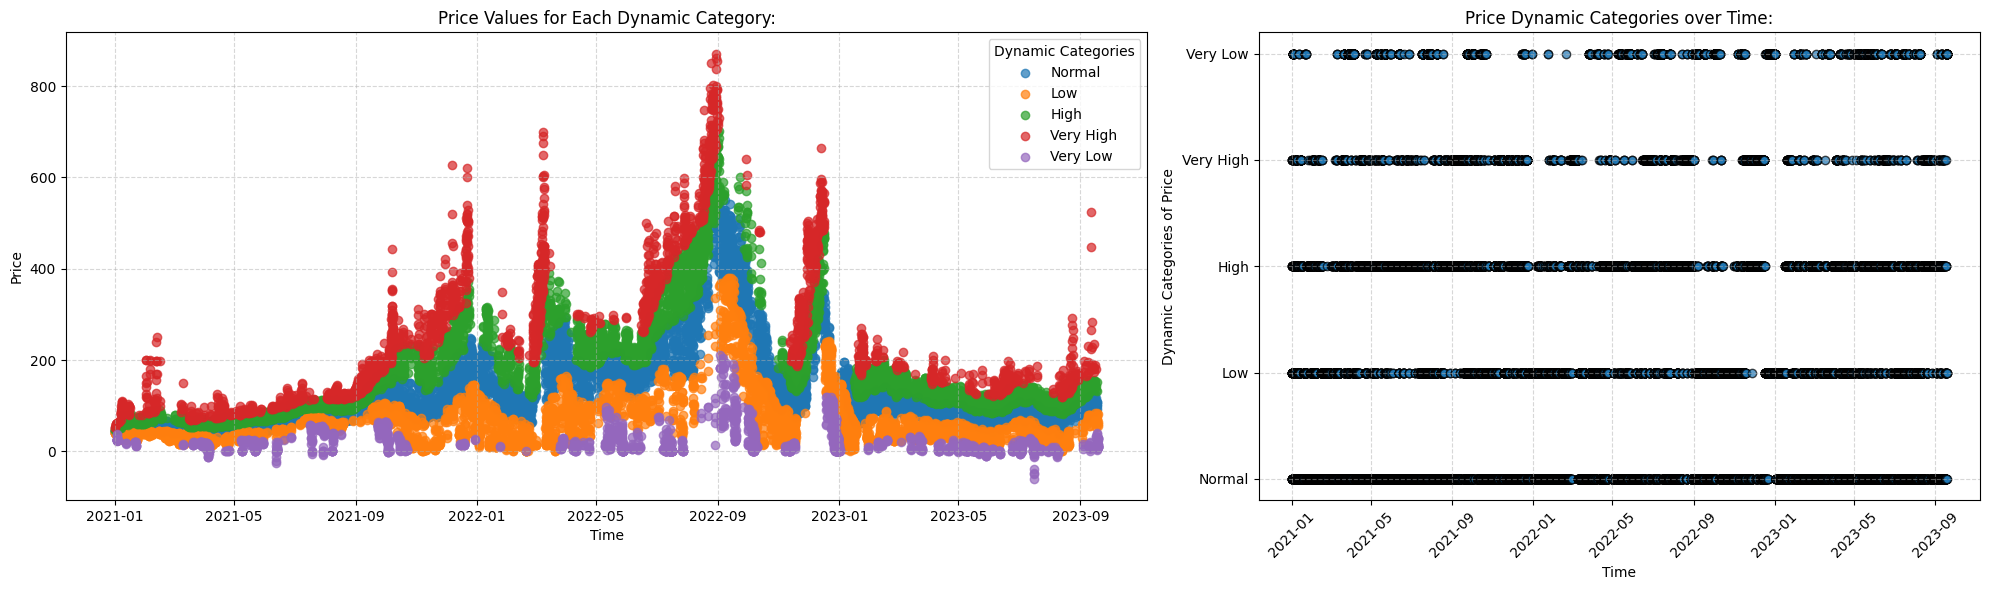

In [190]:
def plot_dynamic_categorization(df, column, time_column):
    """
    Create a subplot with the dynamically categorized data scatter plot on the right
    and line plots of the values for each dynamic category on the left.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the categorized data.
        column (str): The column to analyze and plot.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the categorized data and category-based line plots.
    """
    # Ensure time column is in datetime format and sorted
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    # Get unique categories for dynamic labeling
    unique_categories = df['Category'].dropna().unique()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [3, 2]})

    # Plot scatter plots of values for each dynamic category (left plot)
    for category in unique_categories:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Dynamic Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Dynamic Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Plot scatter plot of dynamic categories over time (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Dynamic Categories over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Dynamic Categories of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Apply function to plot
plot_dynamic_categorization(categorized_data, column='Price', time_column='Datetime')

In [218]:
def calculate_transition_matrix(df, category_column="Category"):
    """
    Calculate the transition probability matrix for categories.

    Args:
    - df: DataFrame with a sequential column of categories.
    - category_column: Name of the column containing the categories.

    Returns:
    - 4x4 transition probability matrix as a DataFrame.
    """
    # Ensure the column exists
    if category_column not in df.columns:
        raise ValueError(f"Column '{category_column}' not found in the DataFrame.")

    # Extract categories from input df

    categories = df[category_column].unique()
    transitions = df[category_column].values

    # Initialize a matrix for counts
    transition_counts = pd.DataFrame(
        np.zeros((len(categories), len(categories))),
        index=categories,
        columns=categories,
    )

    # Count transitions
    for i in range(len(transitions) - 1):
        current_category = transitions[i]
        next_category = transitions[i + 1]
        if current_category in categories and next_category in categories:
            transition_counts.loc[current_category, next_category] += 1

    # Normalize rows to get probabilities
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    # # Debugging: Check row sums after normalization
    # print("Row Sums After Normalization:")
    # print(transition_matrix.sum(axis=1))

    return transition_matrix

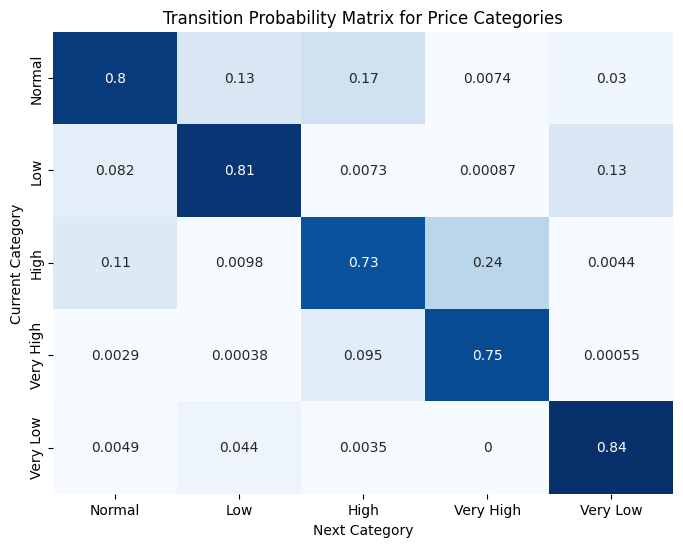

Transition Matrix Check:
State: Normal, Sum of Probabilities: 1.0
State: Low, Sum of Probabilities: 1.0
State: High, Sum of Probabilities: 1.0
State: Very High, Sum of Probabilities: 1.0
State: Very Low, Sum of Probabilities: 1.0


In [219]:
# Calculate transition probabilities
transition_matrix = calculate_transition_matrix(categorized_data).to_dict(orient="index") # Important to get normalized probabilities!!
transition_df = pd.DataFrame(transition_matrix)

# Plot transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_df, annot=True, cmap="Blues", cbar=False)
plt.title("Transition Probability Matrix for Price Categories")
plt.xlabel("Next Category")
plt.ylabel("Current Category")
plt.show()

print("Transition Matrix Check:")
for state, transitions in transition_matrix.items():
    print(f"State: {state}, Sum of Probabilities: {round(sum(transitions.values()),2)}")

In [211]:
class BatteryOptimization:
    def __init__(self, states, actions, price_df, transition_prob, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Optimization problem.
        
        Args:
        - states: List of all possible states (SOC, PriceCategory).
        - actions: List of possible actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_df: DataFrame with columns ['PriceValue', 'PriceCategory'].
        - transition_prob: Dictionary with transition probabilities between price categories.
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.states = states
        self.actions = actions
        self.price_df = price_df.set_index("Category")  # Easier access by category
        self.transition_prob = transition_prob
        self.gamma = gamma
        self.epsilon = epsilon
        self.value_function = np.zeros(len(states))  # Initialize V(s) = 0 for all states
        self.policy = ["Nothing"] * len(states)  # Initialize policy

    def is_valid_action(self, soc, action):
        """Checks if an action is valid for a given SOC."""
        if action == "Discharge" and soc == 0:
            return False  # Cannot discharge at SOC = 0
        if action == "Charge" and soc == 500:
            return False  # Cannot charge at SOC = 500
        return True

    def get_next_state(self, soc, action):
        """Calculates the next SOC based on the action."""
        if action == "Charge" and soc < 500:
            return soc + 100
        elif action == "Discharge" and soc > 0:
            return soc - 100
        return soc  # "Nothing" or out-of-bound action

    def reward(self, action, price_category):
        price_value = self.price_df.loc[price_category, "Price"]
        if isinstance(price_value, pd.Series):
            price_value = price_value.iloc[0] 
        if action == "Charge":
            return -100 * price_value
        elif action == "Discharge":
            return 100 * price_value
        return 0

    def value_iteration(self):
        while True:
            delta = 0
            new_value_function = np.zeros(len(self.states))

            for s, (soc, price_category) in enumerate(self.states):
                action_values = []

                for action in self.actions:
                    if not self.is_valid_action(soc, action):
                        continue  # Skip invalid actions

                    # Calculate next SOC
                    next_soc = self.get_next_state(soc, action)
                    expected_value = 0

                    # Compute expected value for transitioning to next states
                    for next_price_category, prob in self.transition_prob[price_category].items():
                        next_state = (next_soc, next_price_category)
                        if next_state in self.states:
                            next_state_index = self.states.index(next_state)
                            reward = self.reward(action, price_category)
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])

                    action_values.append(expected_value)

                # Update the value for this state
                if action_values:
                    new_value_function[s] = max(action_values)
                else:
                    new_value_function[s] = self.value_function[s]

                delta = max(delta, abs(new_value_function[s] - self.value_function[s]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def extract_policy(self):
        for s, (soc, price_category) in enumerate(self.states):
            action_values = []
    
            for action in self.actions:
                if not self.is_valid_action(soc, action):
                    continue  # Skip invalid actions
                
                # Calculate next SOC
                next_soc = self.get_next_soc(soc, action)
                expected_value = 0
    
                # Compute expected value for transitioning to next states
                for next_price_category, prob in self.transition_matrix[price_category].items():
                    next_state = (next_soc, next_price_category)
                    if next_state in self.states:
                        next_state_index = self.states.index(next_state)
                        reward = self.reward(action, price_category)
                        expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])
    
                action_values.append((expected_value, action))
    
            # Select action with the highest value
            if action_values:
                best_action_value, best_action = max(action_values, key=lambda x: x[0])
                self.policy[s] = best_action
            else:
                self.policy[s] = "Nothing"  # Default if no valid actions


    def solve(self):
        """Runs value iteration and extracts the optimal policy."""
        self.value_iteration()
        self.extract_policy()

In [212]:
class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(
                                action,
                                self.price_series[self.price_series["Category"] == next_category]["Price"].mean(),
                            )
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)

                # Debugging: Print state and valid actions
                print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = self.actions[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


In [213]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
actions = ["Charge", "Discharge", "Nothing"]
price_categories = categorized_data["Category"].unique()

# Initialize and run value iteration
optimizer = BatteryValueIteration(soc_levels, actions, categorized_data, price_categories, transition_matrix)
optimizer.value_iteration()

# Print results
print("-"*50)
print("Value Function:")
for state, value in optimizer.get_value_function().items():
    display(f"State: {state}, Value: {value:.2f}")

Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Normal'), Valid Actions: [-12643.507638487894, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Low'), Valid Actions: [-7281.618925192223, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'High'), Valid Actions: [-17828.015315558667, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Very High'), Valid Actions: [-25649.149700520138, 0.0]
Action: Charge, SOC: 0, Valid: True
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
State: (0, 'Very Low'), Valid Actions: [-3330.1829774067496, 0.0]
Action: Charge, SOC: 100, Valid: True
Action: Discharge, SOC: 100, Valid: True
Action: Nothing, SOC: 100, Valid: Tru

"State: (0, 'Normal'), Value: 431.50"

"State: (0, 'Low'), Value: 933.81"

"State: (0, 'High'), Value: 302.40"

"State: (0, 'Very High'), Value: 213.87"

"State: (0, 'Very Low'), Value: 4885.35"

"State: (100, 'Normal'), Value: 13075.01"

"State: (100, 'Low'), Value: 8215.43"

"State: (100, 'High'), Value: 18130.42"

"State: (100, 'Very High'), Value: 25863.01"

"State: (100, 'Very Low'), Value: 9067.01"

"State: (200, 'Normal'), Value: 24574.69"

"State: (200, 'Low'), Value: 15373.30"

"State: (200, 'High'), Value: 33952.02"

"State: (200, 'Very High'), Value: 47134.51"

"State: (200, 'Very Low'), Value: 13009.17"

"State: (300, 'Normal'), Value: 35029.32"

"State: (300, 'Low'), Value: 22277.39"

"State: (300, 'High'), Value: 47913.16"

"State: (300, 'Very High'), Value: 65009.92"

"State: (300, 'Very Low'), Value: 16722.04"

"State: (400, 'Normal'), Value: 44517.52"

"State: (400, 'Low'), Value: 28845.98"

"State: (400, 'High'), Value: 60207.08"

"State: (400, 'Very High'), Value: 80183.06"

"State: (400, 'Very Low'), Value: 20227.40"

"State: (500, 'Normal'), Value: 53111.10"

"State: (500, 'Low'), Value: 35031.15"

"State: (500, 'High'), Value: 71030.79"

"State: (500, 'Very High'), Value: 93164.11"

"State: (500, 'Very Low'), Value: 23557.58"

In [214]:
print("\nPolicy:")
for state, action in optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")


Policy:
State: (0, 'Normal'), Policy: Discharge
State: (0, 'Low'), Policy: Discharge
State: (0, 'High'), Policy: Discharge
State: (0, 'Very High'), Policy: Discharge
State: (0, 'Very Low'), Policy: Charge
State: (100, 'Normal'), Policy: Discharge
State: (100, 'Low'), Policy: Discharge
State: (100, 'High'), Policy: Discharge
State: (100, 'Very High'), Policy: Discharge
State: (100, 'Very Low'), Policy: Charge
State: (200, 'Normal'), Policy: Discharge
State: (200, 'Low'), Policy: Discharge
State: (200, 'High'), Policy: Discharge
State: (200, 'Very High'), Policy: Discharge
State: (200, 'Very Low'), Policy: Charge
State: (300, 'Normal'), Policy: Discharge
State: (300, 'Low'), Policy: Discharge
State: (300, 'High'), Policy: Discharge
State: (300, 'Very High'), Policy: Discharge
State: (300, 'Very Low'), Policy: Charge
State: (400, 'Normal'), Policy: Discharge
State: (400, 'Low'), Policy: Discharge
State: (400, 'High'), Policy: Discharge
State: (400, 'Very High'), Policy: Discharge
State: 